In [1]:
import pandas as pd
import sys
import os
from sentence_transformers import SentenceTransformer
import umap
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz

In [2]:
df = pd.read_csv('~/Documents/papers/iass-mcc-twitter-colab/data/all_tweets.csv',lineterminator='\n')
df = df[~df.text.str.match('^RT @')]
print(df.shape)
df.head()

(2527453, 4)


,id,created_at,text,author_id
0,1276072350874828800,2020-06-25 08:38:51+00:00,Der #DsiN-Sicherheitsindex 2020 von @sicherimn...,836553428042141697
1,1273664775537516546,2020-06-18 17:12:00+00:00,#Mietmoratorium @Wirtschaft_SPD: Das Gesetz zu...,836553428042141697
2,1174324431000236032,2019-09-18 14:08:56+00:00,Schluss mit der Ausbeutung von Paketboten! Das...,836553428042141697
3,992317054727450625,2018-05-04 08:16:36+00:00,"Monika Hofmann: ""Es war eine aufregende Erfahr...",836553428042141697
4,1214489630650912769,2020-01-07 10:11:06+00:00,Neue #Schlichtungsstelle des #Bundes in @stadt...,836553428042141697


In [3]:
author_df = pd.read_csv('~/Documents/papers/iass-mcc-twitter-colab/data/all_parliamentarians.csv').rename(columns={"id":"author_id"})
print(author_df.shape)
author_df.head()

(2368, 15)


,Nachname,Vorname,Fraktion,Twitter-Name,region,"Name, Vorname",Vorname Nachname,handle,party,parltype,author_id,person__id,person__in_parlperiod,seat_region_name,lcasehandle
0,Ahrens,Sandra,CDU,@sandraAhrens,Bremen,NaN,NaN,sandraAhrens,CDUCSU,Land,NaN,NaN,NaN,NaN,sandraahrens
1,Aulepp,Sascha Karolin,SPD,NaN,Bremen,NaN,NaN,NaN,SPD,Land,NaN,NaN,NaN,NaN,NaN
2,Averwerser,Yvonne,CDU,@Yaverwerser,Bremen,NaN,NaN,Yaverwerser,CDUCSU,Land,NaN,NaN,NaN,NaN,yaverwerser
3,Beck,Peter,Liberal-Konservative Reformer,NaN,Bremen,NaN,NaN,NaN,other,Land,NaN,NaN,NaN,NaN,NaN
4,Bensch,Rainer,CDU,@BenschRainer,Bremen,NaN,NaN,BenschRainer,CDUCSU,Land,NaN,NaN,NaN,NaN,benschrainer


In [4]:
df = df.merge(author_df[['author_id','region','party','parltype']],how="left")
print(df.shape)
df.head()

(2527453, 7)


,id,created_at,text,author_id,region,party,parltype
0,1276072350874828800,2020-06-25 08:38:51+00:00,Der #DsiN-Sicherheitsindex 2020 von @sicherimn...,836553428042141697,NaN,NaN,NaN
1,1273664775537516546,2020-06-18 17:12:00+00:00,#Mietmoratorium @Wirtschaft_SPD: Das Gesetz zu...,836553428042141697,NaN,NaN,NaN
2,1174324431000236032,2019-09-18 14:08:56+00:00,Schluss mit der Ausbeutung von Paketboten! Das...,836553428042141697,NaN,NaN,NaN
3,992317054727450625,2018-05-04 08:16:36+00:00,"Monika Hofmann: ""Es war eine aufregende Erfahr...",836553428042141697,NaN,NaN,NaN
4,1214489630650912769,2020-01-07 10:11:06+00:00,Neue #Schlichtungsstelle des #Bundes in @stadt...,836553428042141697,NaN,NaN,NaN


In [5]:
df = df[pd.notna(df['party'])]
df = df[df['region']=="Bund"]
df['party'] = df['party'].str.upper()

df.shape

(1142384, 7)

In [6]:
df.created_at = pd.to_datetime(df['created_at'])
cutoff = datetime.datetime(2021,1,1,tzinfo=pytz.UTC)
cutoff2 = datetime.datetime(2021,9,20,tzinfo=pytz.UTC)

df = df[(df['created_at']>cutoff) & (df['created_at']<cutoff2)]
df = df.sort_values('created_at')
df = df.set_index('created_at')
print(df.shape)
df.tail()

(167337, 6)


,id,text,author_id,region,party,parltype
created_at,,,,,,
2021-09-19 22:55:52+00:00,1439724955265024002,Manchmal lohnt es sich ältere Gastbeiträge ern...,14784765,Bund,LINKE,Bund
2021-09-19 23:01:38+00:00,1439726407295410183,"@axelgns @OlafScholz Nein, es sind 10 Mio Arbe...",15943222,Bund,SPD,Bund
2021-09-19 23:11:45+00:00,1439728950218010625,Ich freue mich auf dieses Buch. @DirkBrockmann...,3292982985,Bund,SPD,Bund
2021-09-19 23:12:45+00:00,1439729201159057411,@schaefer_berlin Das Kohleausstiegsgesetz ist ...,1423622834,Bund,SPD,Bund
2021-09-19 23:26:35+00:00,1439732683324657665,Das hat nochmal negativ überrascht. Diesel nac...,3292982985,Bund,SPD,Bund


,id,text,author_id,region,party,parltype
created_at,,,,,,
2021-01-01 00:00:56+00:00,1344795706700259329,@kreischer_d @cducsubt Uğur Şahin,16361044,Bund,CDUCSU,Bund
2021-01-01 00:02:04+00:00,1344795991002771456,@mueller_sepp https://t.co/QkqccNfRg7,2885729417,Bund,CDUCSU,Bund
2021-01-01 00:03:28+00:00,1344796343877984256,Alles Gute im neuen Jahr! Es kann nur besser w...,2306519694,Bund,GRUENE,Bund
2021-01-01 00:07:06+00:00,1344797261461676033,Einen guten Start ins neue Jahr. Wir haben vie...,74837812,Bund,LINKE,Bund
2021-01-01 00:08:39+00:00,1344797648688132096,"Den Öko-Spießern, Klimahysterikern und #Covid-...",2545743991,Bund,AFD,Bund
...,...,...,...,...,...,...
2021-09-19 22:55:52+00:00,1439724955265024002,Manchmal lohnt es sich ältere Gastbeiträge ern...,14784765,Bund,LINKE,Bund
2021-09-19 23:01:38+00:00,1439726407295410183,"@axelgns @OlafScholz Nein, es sind 10 Mio Arbe...",15943222,Bund,SPD,Bund
2021-09-19 23:11:45+00:00,1439728950218010625,Ich freue mich auf dieses Buch. @DirkBrockmann...,3292982985,Bund,SPD,Bund


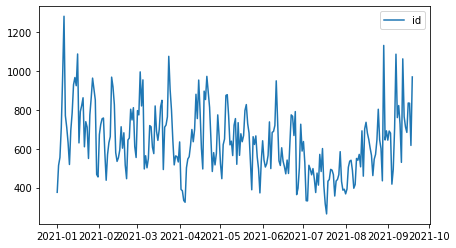

In [8]:
fig, ax = plt.subplots(figsize=(7,4))
counts = df.groupby(df.index.date)['id'].count().astype(int).to_frame()
counts.plot(ax=ax)

In [11]:
redo = False

import spacy
nlp = spacy.load('de_core_news_sm')

def lemmatize(doc):
    doc = nlp(doc)
    result = ' '.join([x.lemma_ for x in doc if not x.is_stop and not x.lemma_=="der"]) 
    return result

if redo:

    df['clean_text'] = df.text.str.replace("(?:\@|https?\://)\S+", "").str.strip()
    df['clean_text'] = df.clean_text.str.replace("&amp;","")
    df['clean_text'] = df['clean_text'].apply(lemmatize)
    
    df.to_csv('source_data/lemmatized_tweets.csv',index=False)
    
else:
    
    lem_df = pd.read_csv('source_data/lemmatized_tweets.csv',lineterminator='\n').dropna().drop(columns="lem_text")
    lem_df = lem_df.rename(columns={"text":"lem_text"})
    merged_df = df.merge(lem_df[['id',"lem_text","clean_text"]],how="outer")
    idx = (merged_df.text!=merged_df.lem_text) | (pd.isna(merged_df.lem_text))
    merged_df.loc[idx,"clean_text"] = merged_df.loc[idx].text.str.replace("(?:\@|https?\://)\S+", "").str.strip()
    merged_df.loc[idx,"clean_text"] = merged_df.loc[idx].clean_text.str.replace("&amp;","")
    merged_df.loc[idx,"clean_text"] = merged_df.loc[idx].clean_text.apply(lemmatize)
    df = merged_df
    df.to_csv('source_data/lemmatized_tweets.csv',index=False)
    
merged_df.head()

,id,text,author_id,region,party,parltype,lem_text,clean_text
0,1344795706700259329,@kreischer_d @cducsubt Uğur Şahin,16361044,Bund,CDUCSU,Bund,@kreischer_d @cducsubt Uğur Şahin,Uğur Şahin
1,1344795991002771456,@mueller_sepp https://t.co/QkqccNfRg7,2885729417,Bund,CDUCSU,Bund,NaN,
2,1344796343877984256,Alles Gute im neuen Jahr! Es kann nur besser w...,2306519694,Bund,GRUENE,Bund,Alles Gute im neuen Jahr! Es kann nur besser w...,alle Gute Jahr ! ich . Auf ’s !
3,1344797261461676033,Einen guten Start ins neue Jahr. Wir haben vie...,74837812,Bund,LINKE,Bund,Einen guten Start ins neue Jahr. Wir haben vie...,einer gut Start Jahr . ich .
4,1344797648688132096,"Den Öko-Spießern, Klimahysterikern und #Covid-...",2545743991,Bund,AFD,Bund,"Den Öko-Spießern, Klimahysterikern und #Covid-...","Öko-Spießern , Klimahysterikern # Covid-Panike..."


,id,lem_text,author_id,region,party,parltype,lem_text,clean_text
0,1344795706700259329,@kreischer_d @cducsubt Uğur Şahin,16361044,Bund,CDUCSU,Bund,@kreischer_d @cducsubt Uğur Şahin,Uğur Şahin
2,1344796343877984256,Alles Gute im neuen Jahr! Es kann nur besser w...,2306519694,Bund,GRUENE,Bund,Alles Gute im neuen Jahr! Es kann nur besser w...,alle Gute Jahr ! ich . Auf ’s !
3,1344797261461676033,Einen guten Start ins neue Jahr. Wir haben vie...,74837812,Bund,LINKE,Bund,Einen guten Start ins neue Jahr. Wir haben vie...,einer gut Start Jahr . ich .
4,1344797648688132096,"Den Öko-Spießern, Klimahysterikern und #Covid-...",2545743991,Bund,AFD,Bund,"Den Öko-Spießern, Klimahysterikern und #Covid-...","Öko-Spießern , Klimahysterikern # Covid-Panike..."
5,1344798920984166400,"Allen ein glückliches, zufriedenes, gesegnetes...",2797812265,Bund,CDUCSU,Bund,"Allen ein glückliches, zufriedenes, gesegnetes...","alle glücklich , zufrieden , gesegnet gesund N..."
...,...,...,...,...,...,...,...,...
167332,1439724955265024002,Manchmal lohnt es sich ältere Gastbeiträge ern...,14784765,Bund,LINKE,Bund,Manchmal lohnt es sich ältere Gastbeiträge ern...,Manchmal lohnen alt Gastbeiträge erneut lesen ...
167333,1439726407295410183,"@axelgns @OlafScholz Nein, es sind 10 Mio Arbe...",15943222,Bund,SPD,Bund,"@axelgns @OlafScholz Nein, es sind 10 Mio Arbe...","nein , 10 Mio Arbeitnehmerinnen Arbeitnehmer ,..."
167334,1439728950218010625,Ich freue mich auf dieses Buch. @DirkBrockmann...,3292982985,Bund,SPD,Bund,Ich freue mich auf dieses Buch. @DirkBrockmann...,ich freuen buchen . absolut Fachmann Modellb...
167335,1439729201159057411,@schaefer_berlin Das Kohleausstiegsgesetz ist ...,1423622834,Bund,SPD,Bund,@schaefer_berlin Das Kohleausstiegsgesetz ist ...,Kohleausstiegsgesetz klug Sozialdemokrat*innen...


In [12]:
# 5 What hashtags are most commonly used

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
regex = r'\B(?!#[0-9_]+\b)(#\w{2,30})\b'

sub_df = df.reset_index()

vec =  CountVectorizer(min_df=1, token_pattern=regex)
X = vec.fit_transform(sub_df.text)
features = vec.get_feature_names()

hashtags = pd.DataFrame()
hashtags['hashtag'] = features

hashtags['total'] = np.array(X.sum(axis=0)).ravel()   

for p in df.party.unique():
    print('\n',p,'\n')
    idx = sub_df[sub_df.party==p].index
    fcounts = np.array(X[idx,:].sum(axis=0)).ravel()   
    hashtags[p] = fcounts
    sorted_counts = np.argsort(fcounts)
    for x in sorted_counts[-10:]:
        print(fcounts[x],features[x])


 CDUCSU 

193 #steineke
203 #cdupt21
216 #btw21
264 #scholz
266 #spd
354 #bundestag
373 #wirecard
388 #corona
389 #cdu
427 #wegenmorgen

 GRUENE 

390 #corona
400 #bonn
433 #triell
447 #afghanistan
486 #cdu
492 #bundestag
592 #allesistdrin
597 #laschet
602 #btw21
825 #klimaschutz

 LINKE 

335 #laschet
349 #bundesregierung
392 #afghanistan
414 #cdurausausderregierung
455 #linke
534 #bundestag
569 #cdu
572 #btw21
646 #wirecard
741 #corona

 AFD 

539 #altenburgerland
551 #greiz
583 #wk194
588 #deutschlandabernormal
607 #wirholendasdirektmandat
626 #gera
865 #brandner
964 #berlin
1138 #bundestag
2346 #afd

 SPD 

170 #thewsdirekt
171 #klimaschutz
189 #wirecard
206 #scholzpacktdasan
222 #triell
272 #bundestag
292 #laschet
313 #corona
326 #cdu
551 #spd

 FDP 

148 #cdu
161 #wirecard
203 #bundesregierung
217 #lockdown
236 #btw21
272 #bundestag
290 #bpt21
583 #vielzutun
603 #corona
623 #fdp


In [13]:
# All hashtags
pd.options.display.max_rows = 999
hashtags.sort_values('total',ascending=False).head(500).to_csv('results/top_hashtags.csv',index=False)
hashtags.sort_values('total',ascending=False).head(10)

,hashtag,total,CDUCSU,GRUENE,LINKE,AFD,SPD,FDP
3242,#bundestag,3062,354,492,534,1138,272,272
4013,#corona,2838,388,390,741,403,313,603
369,#afd,2611,65,40,34,2346,75,51
3632,#cdu,2193,389,486,569,275,326,148
3091,#btw21,1893,216,602,572,121,146,236
24310,#wirecard,1670,373,257,646,44,189,161
2193,#berlin,1636,155,140,118,964,114,145
20313,#spd,1512,266,240,192,137,551,126
12867,#laschet,1504,106,597,335,95,292,79
11958,#klimaschutz,1338,90,825,179,19,171,54


In [14]:
# 5 What hashtags are most commonly used

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
regex = r'\b(?<!#)(\w{2,30})\b'

sub_df = df.reset_index()

vec =  TfidfVectorizer(min_df=1, token_pattern=regex,sublinear_tf=True)
vec =  CountVectorizer(min_df=1, token_pattern=regex)
term_X = vec.fit_transform(sub_df.clean_text)
term_features = vec.get_feature_names()

terms = pd.DataFrame()
terms['hashtag'] = term_features

terms['total'] = np.array(term_X.sum(axis=0)).ravel()   

for p in df.party.unique():
    print('\n',p,'\n')
    idx = sub_df[sub_df.party==p].index
    fcounts = np.array(term_X[idx,:].sum(axis=0)).ravel()   
    terms[p] = fcounts
    sorted_counts = np.argsort(fcounts)
    for x in sorted_counts[-10:]:
        print(fcounts[x],term_features[x])


 CDUCSU 

747 mensch
764 heute
764 land
827 jahr
833 mal
896 cdu
957 danken
1046 und
1822 mein
7423 ich

 GRUENE 

1095 danken
1211 cdu
1265 innen
1321 mensch
1418 klimaschutz
1509 brauchen
1528 jahr
1712 und
1797 mein
7907 ich

 LINKE 

1206 cdu
1240 bundestag
1256 innen
1412 mal
1489 jahr
1514 aber
1706 mensch
1717 und
2176 mein
10181 ich

 AFD 

671 jahr
677 mal
716 deutschland
822 und
900 brandner
1052 mein
1142 berlin
1353 bundestag
2887 afd
4303 ich

 SPD 

902 sein
968 the
1014 aber
1067 mensch
1262 mal
1295 jahr
1313 spd
1777 und
1838 mein
8790 ich

 FDP 

972 mensch
984 jahr
1005 danken
1093 und
1130 brauchen
1202 corona
1526 fdp
1572 mein
2668 tb
8282 ich


In [15]:
terms.sort_values('total',ascending=False).head(500).to_csv('results/top_terms.csv',index=False)
terms.sort_values('total',ascending=False).head(10)

,hashtag,total,CDUCSU,GRUENE,LINKE,AFD,SPD,FDP
50044,ich,46886,7423,7907,10181,4303,8790,8282
68417,mein,10257,1822,1797,2176,1052,1838,1572
106665,und,8167,1046,1712,1717,822,1777,1093
53718,jahr,6794,827,1528,1489,671,1295,984
68684,mensch,6183,747,1321,1706,370,1067,972
66646,mal,6127,833,998,1412,677,1262,945
18036,bundestag,5888,688,1086,1240,1353,811,710
16838,brauchen,5599,711,1509,1164,216,869,1130
2113,aber,5192,565,851,1514,414,1014,834
20954,corona,5150,689,760,1158,650,691,1202


In [16]:
# 5 What hashtags are most commonly used

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
regex = r'\b(?<!#)(\w{2,30})\b'

sub_df = df.reset_index()

vec =  TfidfVectorizer(min_df=1, token_pattern=regex,sublinear_tf=True)
vec =  CountVectorizer(min_df=1, token_pattern=regex, ngram_range=(2,2))
bigram_X = vec.fit_transform(sub_df.clean_text)
bigram_features = vec.get_feature_names()

bigrams = pd.DataFrame()
bigrams['hashtag'] = bigram_features

bigrams['total'] = np.array(bigram_X.sum(axis=0)).ravel()   

for p in df.party.unique():
    print('\n',p,'\n')
    idx = sub_df[sub_df.party==p].index
    fcounts = np.array(bigram_X[idx,:].sum(axis=0)).ravel()   
    bigrams[p] = fcounts
    sorted_counts = np.argsort(fcounts)
    for x in sorted_counts[-10:]:
        print(fcounts[x],bigram_features[x])


 CDUCSU 

106 voll impfschutz
106 ich wünsche
109 ich finden
119 mindestens impfen
174 olaf scholz
182 viel dank
187 steineke fürsieda
205 ich freuen
235 ich brauchen
268 herzliche glückwunsch

 GRUENE 

124 armin laschet
126 16 jahr
131 viel dank
134 olaf scholz
143 letzt jahr
195 csu spd
286 ich freuen
318 herzliche glückwunsch
464 cdu csu
572 ich brauchen

 LINKE 

109 soziale gerechtigkeit
110 mieter innen
122 ich fordern
131 herzliche glückwunsch
156 corona krise
162 ich freuen
226 ich finden
240 cdu csu
260 die linke
427 ich brauchen

 AFD 

246 thüringen deutschlandabernormal
253 deutschlandabernormal wirholendasdirektmandat
271 wirholendasdirektmandat gera
283 afd thüringen
371 greiz altenburgerland
493 gera greiz
502 altenburgerland wk194
548 wk194 berlin
851 bundestag brandner
861 berlin bundestag

 SPD 

102 zum beispiel
112 delta variante
121 of the
122 olaf scholz
142 ich finden
147 viel dank
206 cdu csu
209 ich freuen
255 ich brauchen
320 herzliche glückwunsch

 FDP 

10

In [17]:
bigrams.sort_values('total',ascending=False).head(500).to_csv('results/top_bigrams.csv',index=False)
bigrams.sort_values('total',ascending=False).head(50)

,hashtag,total,CDUCSU,GRUENE,LINKE,AFD,SPD,FDP
486348,ich brauchen,1966,235,572,427,61,255,416
465258,herzliche glückwunsch,1258,268,318,131,39,320,182
193084,cdu csu,1152,74,464,240,62,206,106
487725,ich freuen,1110,205,286,162,58,209,190
133937,berlin bundestag,874,7,1,0,861,5,0
181795,bundestag brandner,851,0,0,0,851,0,0
1059359,viel dank,824,182,131,107,71,147,186
487578,ich finden,719,109,122,226,31,142,89
747756,olaf scholz,583,174,134,85,15,122,53
1122951,wk194 berlin,548,0,0,0,548,0,0


In [18]:
term_topics = pd.read_excel('data/woerter_und_hashtags_v3.xlsx')
term_topics.head()

,hashtag,topic,Unnamed: 2
0,bundestag,politik-intern,NaN
1,corona,corona,NaN
2,cdu,parteien,NaN
3,danken,zusammenhalt,NaN
4,afd,parteien,NaN


In [19]:
topics = []
for topic, group in term_topics.groupby('topic'):
    topics.append(topic)
    df[topic]=0
    cloc = df.columns.get_loc(topic)
    for term in group.hashtag.unique():
        term = str(term)
        if "#" in term:
            x = X
            feat = features
        else:
            x = term_X
            feat = term_features
            term_id = np.argwhere(np.array(feat)==term).ravel()
            idx = x[:,term_id].nonzero()[0] 
            df.iloc[idx,cloc] = 1

In [20]:
topic_ds = [
    {"name":"digitales","keywords":[
        "digital\w* *bildung",
        "digital\w* *verwaltung",
        "^(?=.*5g)(?!.*(impf|covid|pandemie|corona)).*",
        "automatisier(en|t|ung)",
        "digitale\w* *\w*ämt"
    ]},
    {"name":"verkehr","keywords": ["^(?=.*auto)(?!.*matisier).*",]},
    {"name": "arbeit", "keywords": ["beruf(?!en)"]},
    {"name": "außenpolitik", "keywords": ["vereint\w* *nationen","(?<!ent)rüstung"]},
    {"name": "familien", "keywords": ["^(?=.*familien)(?!.*(angehörige|opfer)).*"]},
    {"name": "wohnen", "keywords": ["bauen\W*bauen\W*bauen"]},
    {"name": "gewalt", "keywords": ["^(?=.*gewalt)(?!.*(vierte|dritte)).*"]}
]
topic_names = []
redo = True
for t in topic_ds:
    print(t)
    if t["name"] not in topics:
        topics.append(t["name"])
    for term in t["keywords"]:
        df.loc[df['text'].str.lower().str.contains(term.lower()),t["name"]] = 1

df.head()

{'name': 'digitales', 'keywords': ['digital\\w* *bildung', 'digital\\w* *verwaltung', '^(?=.*5g)(?!.*(impf|covid|pandemie|corona)).*', 'automatisier(en|t|ung)', 'digitale\\w* *\\w*ämt']}


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


{'name': 'verkehr', 'keywords': ['^(?=.*auto)(?!.*matisier).*']}
{'name': 'arbeit', 'keywords': ['beruf(?!en)']}
{'name': 'außenpolitik', 'keywords': ['vereint\\w* *nationen', '(?<!ent)rüstung']}
{'name': 'familien', 'keywords': ['^(?=.*familien)(?!.*(angehörige|opfer)).*']}
{'name': 'wohnen', 'keywords': ['bauen\\W*bauen\\W*bauen']}
{'name': 'gewalt', 'keywords': ['^(?=.*gewalt)(?!.*(vierte|dritte)).*']}


,id,text,author_id,region,party,parltype,lem_text,clean_text,0,?,...,sozialpolitik,staat,verkehr,wahlen,wirtschaft,wissenschaft,wohnen,zukunft,zusammenhalt,familien
0,1344795706700259329,@kreischer_d @cducsubt Uğur Şahin,16361044,Bund,CDUCSU,Bund,@kreischer_d @cducsubt Uğur Şahin,Uğur Şahin,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1,1344795991002771456,@mueller_sepp https://t.co/QkqccNfRg7,2885729417,Bund,CDUCSU,Bund,NaN,,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2,1344796343877984256,Alles Gute im neuen Jahr! Es kann nur besser w...,2306519694,Bund,GRUENE,Bund,Alles Gute im neuen Jahr! Es kann nur besser w...,alle Gute Jahr ! ich . Auf ’s !,0,0,...,0,0,0,0,0,0,0,0,0,NaN
3,1344797261461676033,Einen guten Start ins neue Jahr. Wir haben vie...,74837812,Bund,LINKE,Bund,Einen guten Start ins neue Jahr. Wir haben vie...,einer gut Start Jahr . ich .,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,1344797648688132096,"Den Öko-Spießern, Klimahysterikern und #Covid-...",2545743991,Bund,AFD,Bund,"Den Öko-Spießern, Klimahysterikern und #Covid-...","Öko-Spießern , Klimahysterikern # Covid-Panike...",0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [21]:
df.to_csv('source_data/ht_term_annotated_tweets.csv',index=False)

In [22]:
cdict = {'afd': '#009EE0',
 'bp': None,
 'cducsu': '#000000',
 'dp': None,
 'drp': None,
 'dzp': None,
 'fdp': '#FFED00',
 'fraktionslos': None,
 'gb/bhe': None,
 'gruene': '#64A12D',
 'kpd': None,
 'linke': '#8C3473',
 'other': None,
 'parteilos': None,
 'pds': None,
 'spd': '#EB001F',
 'wav': None}

In [23]:
if type(df.index) == pd.core.indexes.numeric.Int64Index:
    df_times = pd.read_csv('~/Documents/papers/iass-mcc-twitter-colab/data/all_tweets.csv',lineterminator='\n')
    df_times['created_at'] = pd.to_datetime(df_times['created_at'])
    df = df.merge(df_times[['id','created_at']])
    df = df.set_index("created_at")
    
df.head()

,id,text,author_id,region,party,parltype,lem_text,clean_text,0,?,...,sozialpolitik,staat,verkehr,wahlen,wirtschaft,wissenschaft,wohnen,zukunft,zusammenhalt,familien
created_at,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:56+00:00,1344795706700259329,@kreischer_d @cducsubt Uğur Şahin,16361044,Bund,CDUCSU,Bund,@kreischer_d @cducsubt Uğur Şahin,Uğur Şahin,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2021-01-01 00:02:04+00:00,1344795991002771456,@mueller_sepp https://t.co/QkqccNfRg7,2885729417,Bund,CDUCSU,Bund,NaN,,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2021-01-01 00:03:28+00:00,1344796343877984256,Alles Gute im neuen Jahr! Es kann nur besser w...,2306519694,Bund,GRUENE,Bund,Alles Gute im neuen Jahr! Es kann nur besser w...,alle Gute Jahr ! ich . Auf ’s !,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2021-01-01 00:07:06+00:00,1344797261461676033,Einen guten Start ins neue Jahr. Wir haben vie...,74837812,Bund,LINKE,Bund,Einen guten Start ins neue Jahr. Wir haben vie...,einer gut Start Jahr . ich .,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2021-01-01 00:08:39+00:00,1344797648688132096,"Den Öko-Spießern, Klimahysterikern und #Covid-...",2545743991,Bund,AFD,Bund,"Den Öko-Spießern, Klimahysterikern und #Covid-...","Öko-Spießern , Klimahysterikern # Covid-Panike...",0,0,...,0,0,0,0,0,0,0,0,0,NaN


#####
#####
 14
#####
#####
Minimum periods:  14
0
mentioned  27354  times
?
mentioned  23  times
agrar
mentioned  72  times
arbeit
mentioned  3835  times
außenpolitik
mentioned  5869  times
bildung
mentioned  2512  times
bürokratie
mentioned  469  times
corona
mentioned  13861  times


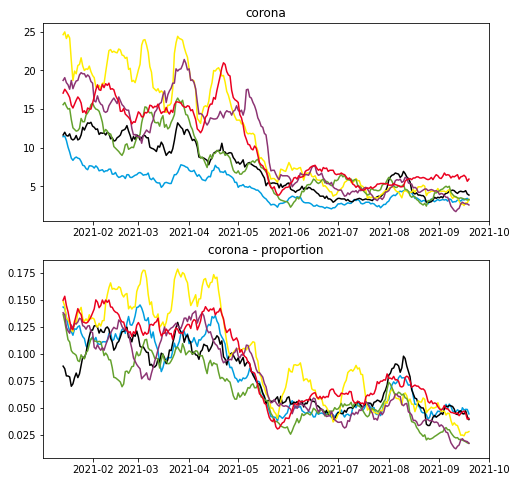

debatte
mentioned  12916  times
digitales
mentioned  1280  times
diskriminierung
mentioned  1462  times
einfamilienhaus
mentioned  89  times
emotion
mentioned  674  times
engagement
mentioned  596  times
erinnerung
mentioned  620  times
europa
mentioned  3478  times
familie
mentioned  2964  times
freiheit
mentioned  1284  times
gesellschaft
mentioned  1215  times
gewalt
mentioned  1123  times
gleichberechtigung
mentioned  357  times
internationales
mentioned  91  times
klima
mentioned  5190  times


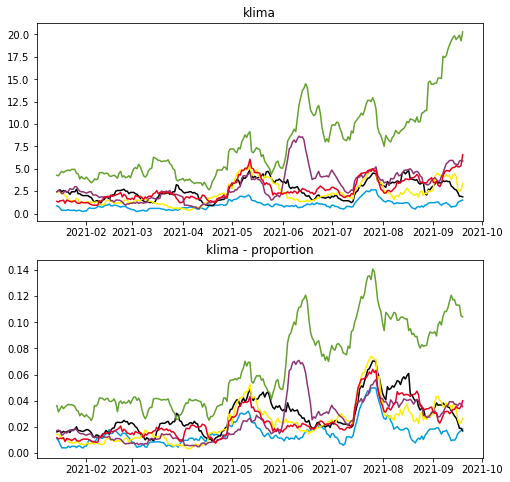

korruption
mentioned  2736  times
medien
mentioned  2379  times
menschenrechte
mentioned  774  times
migration
mentioned  958  times
parteien
mentioned  19973  times
politik-intern
mentioned  26115  times
politiker
mentioned  8435  times
recht
mentioned  1069  times
religion
mentioned  588  times
rente
mentioned  553  times
sicherheit
mentioned  923  times
sozialpolitik
mentioned  2942  times
staat
mentioned  6594  times
verkehr
mentioned  2290  times
wahlen
mentioned  5225  times


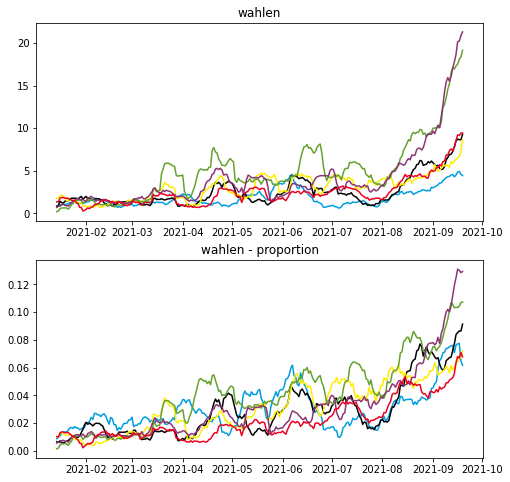

wirtschaft
mentioned  11774  times
wissenschaft
mentioned  686  times
wohnen
mentioned  1804  times


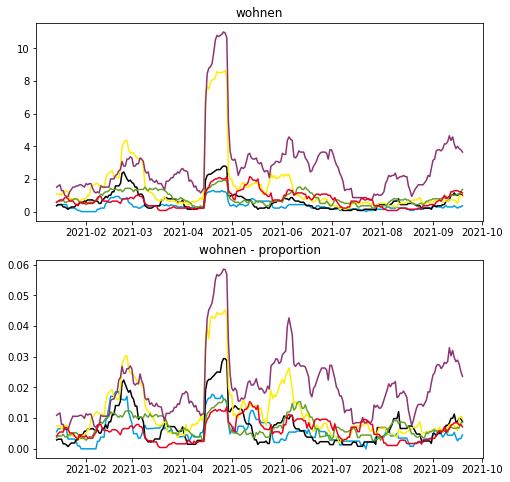

zukunft
mentioned  1691  times
zusammenhalt
mentioned  13435  times
familien
mentioned  1045  times
#####
#####
 14
#####
#####
Minimum periods:  7
0
mentioned  27354  times
?
mentioned  23  times
agrar
mentioned  72  times
arbeit
mentioned  3835  times
außenpolitik
mentioned  5869  times
bildung
mentioned  2512  times
bürokratie
mentioned  469  times
corona
mentioned  13861  times


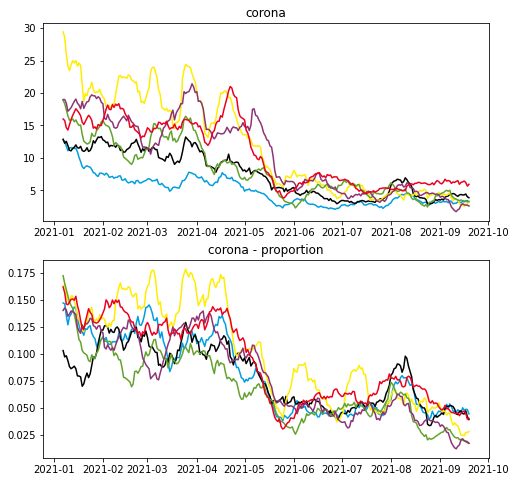

debatte
mentioned  12916  times
digitales
mentioned  1280  times
diskriminierung
mentioned  1462  times
einfamilienhaus
mentioned  89  times
emotion
mentioned  674  times
engagement
mentioned  596  times
erinnerung
mentioned  620  times
europa
mentioned  3478  times
familie
mentioned  2964  times
freiheit
mentioned  1284  times
gesellschaft
mentioned  1215  times
gewalt
mentioned  1123  times
gleichberechtigung
mentioned  357  times
internationales
mentioned  91  times
klima
mentioned  5190  times


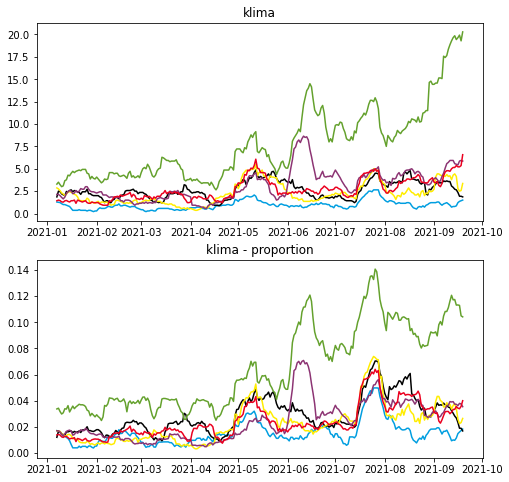

korruption
mentioned  2736  times
medien
mentioned  2379  times
menschenrechte
mentioned  774  times
migration
mentioned  958  times
parteien
mentioned  19973  times
politik-intern
mentioned  26115  times
politiker
mentioned  8435  times
recht
mentioned  1069  times
religion
mentioned  588  times
rente
mentioned  553  times
sicherheit
mentioned  923  times
sozialpolitik
mentioned  2942  times
staat
mentioned  6594  times
verkehr
mentioned  2290  times
wahlen
mentioned  5225  times


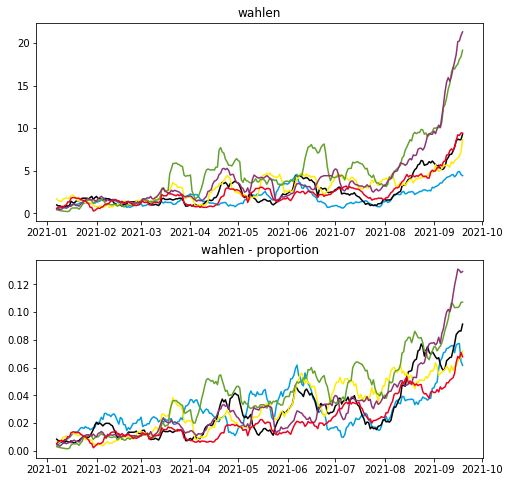

wirtschaft
mentioned  11774  times
wissenschaft
mentioned  686  times
wohnen
mentioned  1804  times


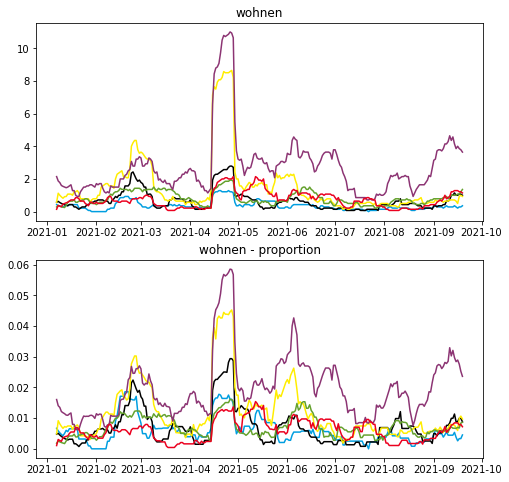

zukunft
mentioned  1691  times
zusammenhalt
mentioned  13435  times
familien
mentioned  1045  times
#####
#####
 30
#####
#####
Minimum periods:  30
0
mentioned  27354  times
?
mentioned  23  times
agrar
mentioned  72  times
arbeit
mentioned  3835  times
außenpolitik
mentioned  5869  times
bildung
mentioned  2512  times
bürokratie
mentioned  469  times
corona
mentioned  13861  times


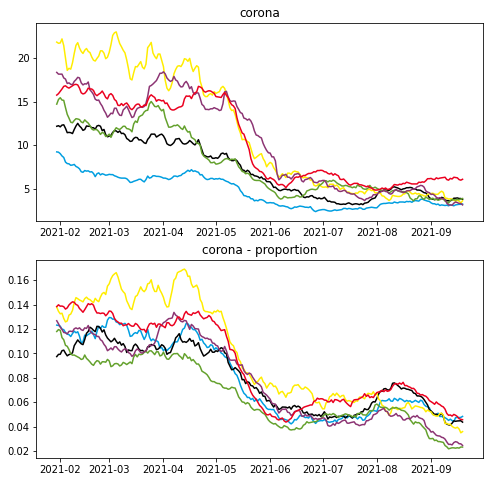

debatte
mentioned  12916  times
digitales
mentioned  1280  times
diskriminierung
mentioned  1462  times
einfamilienhaus
mentioned  89  times
emotion
mentioned  674  times
engagement
mentioned  596  times
erinnerung
mentioned  620  times
europa
mentioned  3478  times
familie
mentioned  2964  times
freiheit
mentioned  1284  times
gesellschaft
mentioned  1215  times
gewalt
mentioned  1123  times
gleichberechtigung
mentioned  357  times
internationales
mentioned  91  times
klima
mentioned  5190  times


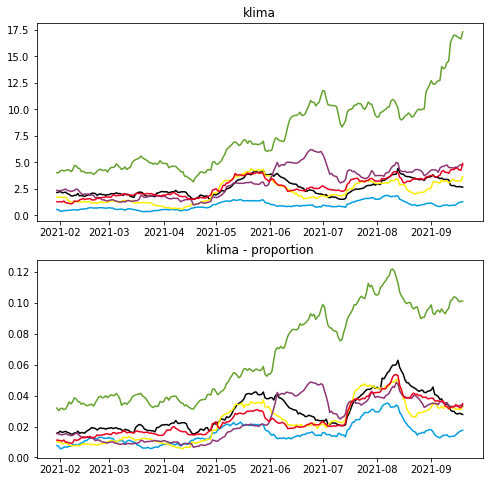

korruption
mentioned  2736  times
medien
mentioned  2379  times
menschenrechte
mentioned  774  times
migration
mentioned  958  times
parteien
mentioned  19973  times
politik-intern
mentioned  26115  times
politiker
mentioned  8435  times
recht
mentioned  1069  times
religion
mentioned  588  times
rente
mentioned  553  times
sicherheit
mentioned  923  times
sozialpolitik
mentioned  2942  times
staat
mentioned  6594  times
verkehr
mentioned  2290  times
wahlen
mentioned  5225  times


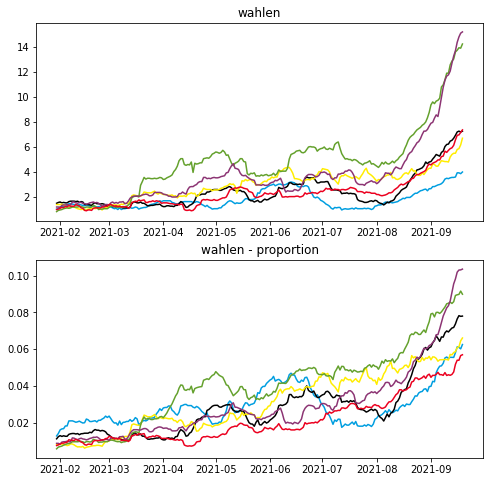

wirtschaft
mentioned  11774  times
wissenschaft
mentioned  686  times
wohnen
mentioned  1804  times


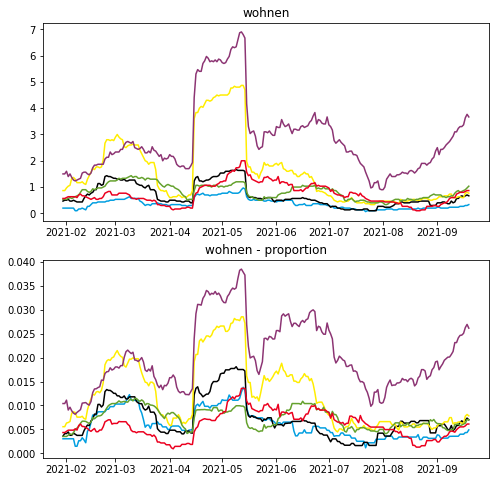

zukunft
mentioned  1691  times
zusammenhalt
mentioned  13435  times
familien
mentioned  1045  times
#####
#####
 30
#####
#####
Minimum periods:  7
0
mentioned  27354  times
?
mentioned  23  times
agrar
mentioned  72  times
arbeit
mentioned  3835  times
außenpolitik
mentioned  5869  times
bildung
mentioned  2512  times
bürokratie
mentioned  469  times
corona
mentioned  13861  times


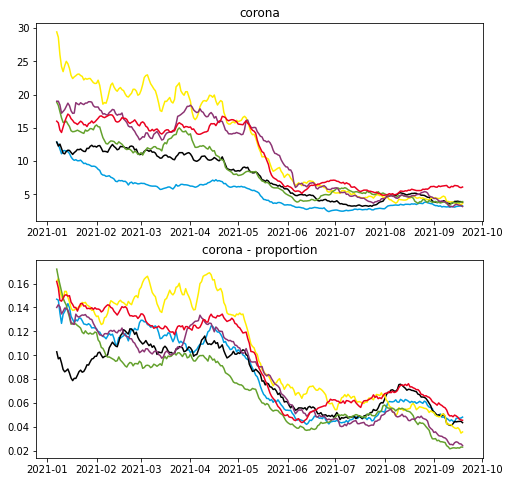

debatte
mentioned  12916  times
digitales
mentioned  1280  times
diskriminierung
mentioned  1462  times
einfamilienhaus
mentioned  89  times
emotion
mentioned  674  times
engagement
mentioned  596  times
erinnerung
mentioned  620  times
europa
mentioned  3478  times
familie
mentioned  2964  times
freiheit
mentioned  1284  times
gesellschaft
mentioned  1215  times
gewalt
mentioned  1123  times
gleichberechtigung
mentioned  357  times
internationales
mentioned  91  times
klima
mentioned  5190  times


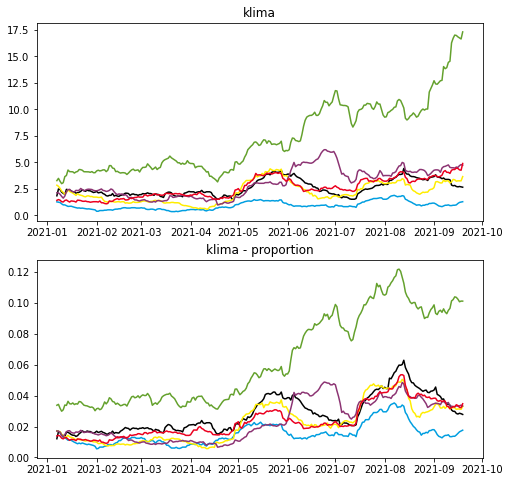

korruption
mentioned  2736  times
medien
mentioned  2379  times
menschenrechte
mentioned  774  times
migration
mentioned  958  times
parteien
mentioned  19973  times
politik-intern
mentioned  26115  times
politiker
mentioned  8435  times
recht
mentioned  1069  times
religion
mentioned  588  times
rente
mentioned  553  times
sicherheit
mentioned  923  times
sozialpolitik
mentioned  2942  times
staat
mentioned  6594  times
verkehr
mentioned  2290  times
wahlen
mentioned  5225  times


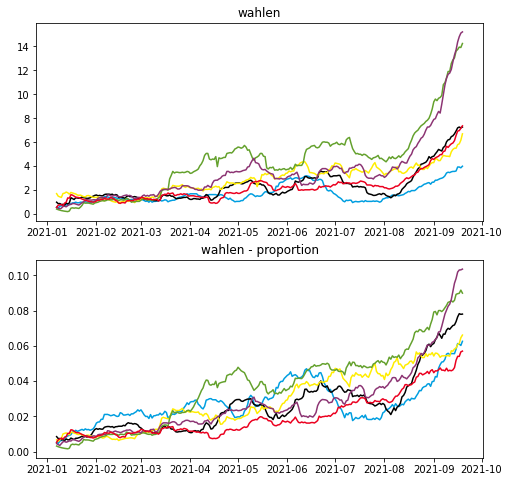

wirtschaft
mentioned  11774  times
wissenschaft
mentioned  686  times
wohnen
mentioned  1804  times


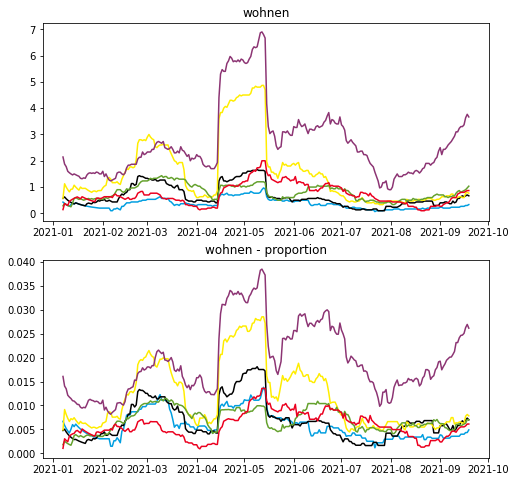

zukunft
mentioned  1691  times
zusammenhalt
mentioned  13435  times
familien
mentioned  1045  times
#####
#####
 60
#####
#####
Minimum periods:  60
0
mentioned  27354  times
?
mentioned  23  times
agrar
mentioned  72  times
arbeit
mentioned  3835  times
außenpolitik
mentioned  5869  times
bildung
mentioned  2512  times
bürokratie
mentioned  469  times
corona
mentioned  13861  times


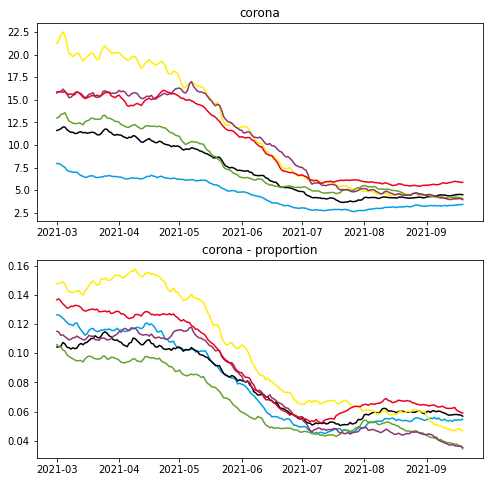

debatte
mentioned  12916  times
digitales
mentioned  1280  times
diskriminierung
mentioned  1462  times
einfamilienhaus
mentioned  89  times
emotion
mentioned  674  times
engagement
mentioned  596  times
erinnerung
mentioned  620  times
europa
mentioned  3478  times
familie
mentioned  2964  times
freiheit
mentioned  1284  times
gesellschaft
mentioned  1215  times
gewalt
mentioned  1123  times
gleichberechtigung
mentioned  357  times
internationales
mentioned  91  times
klima
mentioned  5190  times


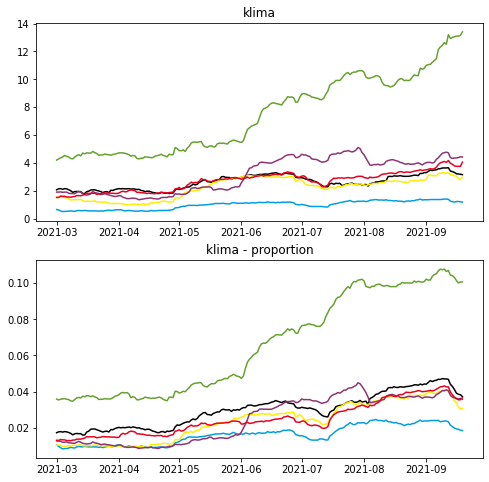

korruption
mentioned  2736  times
medien
mentioned  2379  times
menschenrechte
mentioned  774  times
migration
mentioned  958  times
parteien
mentioned  19973  times
politik-intern
mentioned  26115  times
politiker
mentioned  8435  times
recht
mentioned  1069  times
religion
mentioned  588  times
rente
mentioned  553  times
sicherheit
mentioned  923  times
sozialpolitik
mentioned  2942  times
staat
mentioned  6594  times
verkehr
mentioned  2290  times
wahlen
mentioned  5225  times


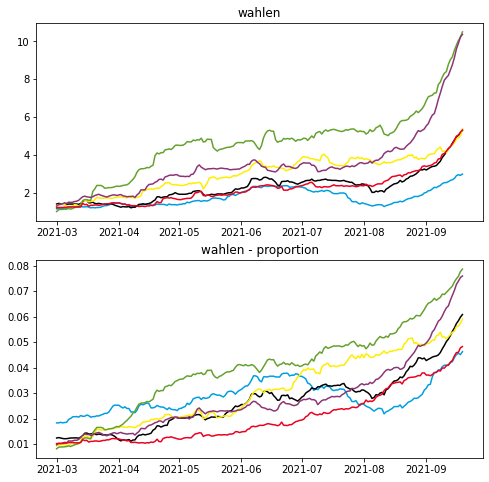

wirtschaft
mentioned  11774  times
wissenschaft
mentioned  686  times
wohnen
mentioned  1804  times


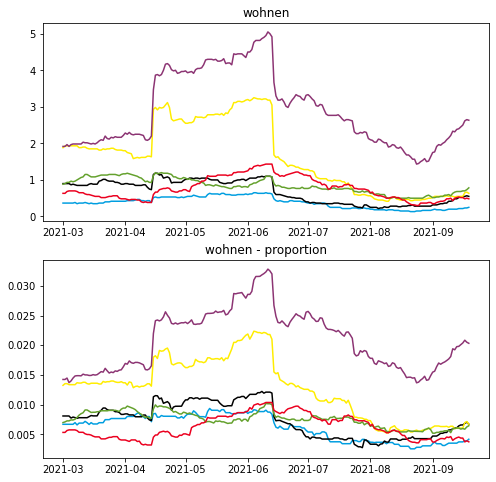

zukunft
mentioned  1691  times
zusammenhalt
mentioned  13435  times
familien
mentioned  1045  times
#####
#####
 60
#####
#####
Minimum periods:  7
0
mentioned  27354  times
?
mentioned  23  times
agrar
mentioned  72  times
arbeit
mentioned  3835  times
außenpolitik
mentioned  5869  times
bildung
mentioned  2512  times
bürokratie
mentioned  469  times
corona
mentioned  13861  times


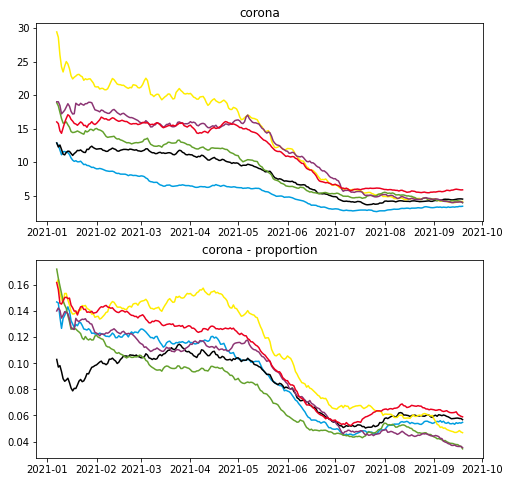

debatte
mentioned  12916  times
digitales
mentioned  1280  times
diskriminierung
mentioned  1462  times
einfamilienhaus
mentioned  89  times
emotion
mentioned  674  times
engagement
mentioned  596  times
erinnerung
mentioned  620  times
europa
mentioned  3478  times
familie
mentioned  2964  times
freiheit
mentioned  1284  times
gesellschaft
mentioned  1215  times
gewalt
mentioned  1123  times
gleichberechtigung
mentioned  357  times
internationales
mentioned  91  times
klima
mentioned  5190  times


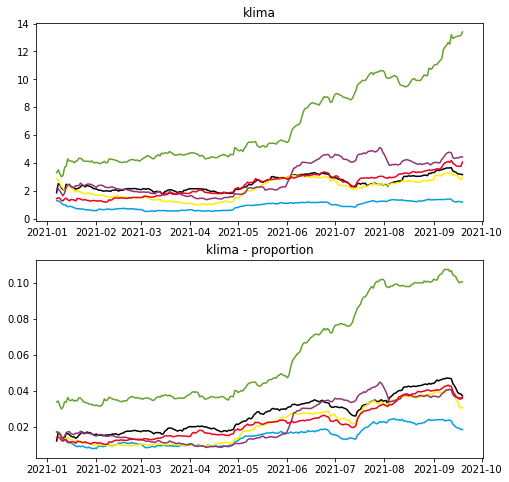

korruption
mentioned  2736  times
medien
mentioned  2379  times
menschenrechte
mentioned  774  times
migration
mentioned  958  times
parteien
mentioned  19973  times
politik-intern
mentioned  26115  times
politiker
mentioned  8435  times
recht
mentioned  1069  times
religion
mentioned  588  times
rente
mentioned  553  times
sicherheit
mentioned  923  times
sozialpolitik
mentioned  2942  times
staat
mentioned  6594  times
verkehr
mentioned  2290  times
wahlen
mentioned  5225  times


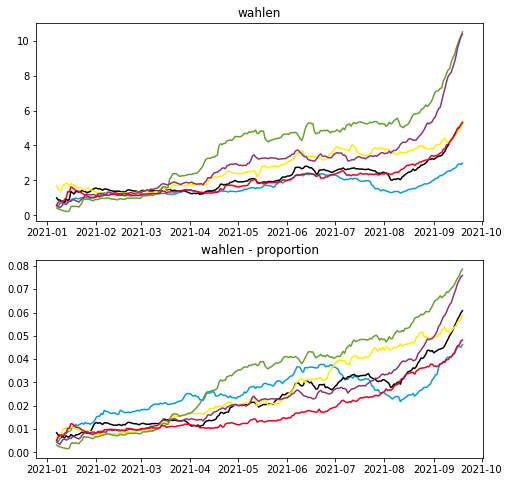

wirtschaft
mentioned  11774  times
wissenschaft
mentioned  686  times
wohnen
mentioned  1804  times


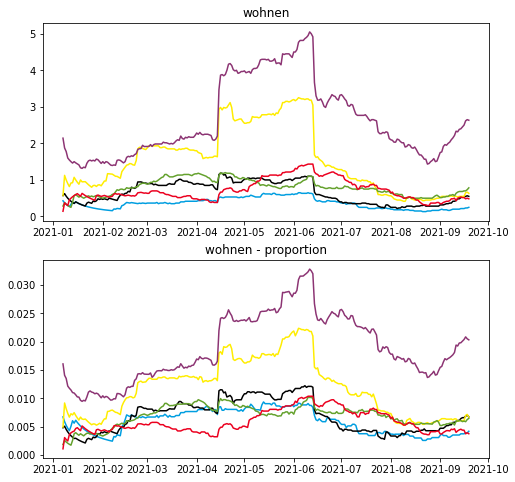

zukunft
mentioned  1691  times
zusammenhalt
mentioned  13435  times
familien
mentioned  1045  times


In [37]:

for days in [14,30,60]:
    
    for min_periods in [days,7]:

        print("#####\n#####\n",days)
        
        print("#####\n#####\nMinimum periods: ", min_periods,)
        for j,c in enumerate(topics):

            print(c)

            sub_df = df[df[c]==1].reset_index()

            print("mentioned ", sub_df.shape[0], " times")
            if not os.path.isdir(f"results/{c}"):
                os.mkdir(f"results/{c}")

            regex = r'\B(?!#[0-9_]+\b)(#\w{2,30})\b'

            vec =  CountVectorizer(min_df=1, token_pattern=regex)
            X = vec.fit_transform(sub_df.text)
            features = vec.get_feature_names()

            hashtags = pd.DataFrame()
            hashtags['hashtag'] = features

            hashtags['total'] = np.array(X.sum(axis=0)).ravel()   

            for p in df.party.unique():
                idx = sub_df[sub_df.party==p].index
                fcounts = np.array(X[idx,:].sum(axis=0)).ravel()   
                hashtags[p] = fcounts
                sorted_counts = np.argsort(fcounts)

            hashtags.sort_values('total',ascending=False).head(500).to_csv(f'results/{c}/top_hashtags.csv',index=False)

            regex = r'\b(?<!#)(\w{2,30})\b'

            vec =  CountVectorizer(min_df=1, token_pattern=regex)
            term_X = vec.fit_transform(sub_df.clean_text)
            term_features = vec.get_feature_names()

            terms = pd.DataFrame()
            terms['hashtag'] = term_features

            terms['total'] = np.array(term_X.sum(axis=0)).ravel()   

            for p in df.party.unique():
                idx = sub_df[sub_df.party==p].index
                fcounts = np.array(term_X[idx,:].sum(axis=0)).ravel()   
                terms[p] = fcounts
                sorted_counts = np.argsort(fcounts)

            terms.sort_values('total',ascending=False).head(500).to_csv(f'results/{c}/top_terms.csv',index=False)

            fig, axs = plt.subplots(2, figsize=(8,8))

            count_df = pd.DataFrame()

            ax = axs[0]
            for party, group in df.groupby('party'):
                counts = group.groupby(group.index.date)[c].sum()
                counts = counts.rolling(days, min_periods=min_periods).mean()
                count_df = count_df.merge(counts.to_frame(party),left_index=True, right_index=True,how="outer")
                ax.plot(counts, color=cdict[party.lower()])

            ax.set_title(c)

            ax = axs[1]
            for party, group in df.groupby('party'):
                counts = group.groupby(group.index.date)[c].sum() / group.groupby(group.index.date)[c].count()
                counts = counts.rolling(days, min_periods=min_periods).mean()
                count_df = count_df.merge(counts.to_frame(f"{party} - norm"),left_index=True, right_index=True,how="outer")
                ax.plot(counts, color=cdict[party.lower()])

            ax.set_title(f"{c} - proportion")

            plt.savefig(f"results/{c}/topic_over_time_{days}_days_{min_periods}_minimum_days.png",bbox_inches="tight")
            count_df.to_csv(f"results/{c}/counts_{days}_days_{min_periods}_minimum_days.csv")

            if c in ["klima","corona","wohnen","wahlen"]:
                plt.show()
            else:
                plt.close()


In [25]:
sub_df = df[(df['klima']==1)&(df['party']=="GRUENE") & (df.index.date>datetime.date(2021,9,1))]
sub_df.groupby(sub_df.index.date)['id'].count()

2021-09-02    12
2021-09-03     9
2021-09-04    16
2021-09-05    15
2021-09-06    12
2021-09-07    46
2021-09-08    15
2021-09-09    13
2021-09-10    19
2021-09-11    12
2021-09-12    58
2021-09-13    18
2021-09-14    17
2021-09-15    10
2021-09-16    15
2021-09-17    13
2021-09-18     7
2021-09-19    29
Name: id, dtype: int64

In [26]:
sub_df.head().text.values

array(['So ist es, deshalb wollen auch wir @Die_Gruenen den CO2-Preis dort erheben wo die größte Lenkungswirkung erzieht wird - beim Eigentümer. https://t.co/s2oLfHhtAE',
       '„#Klimaschutz wird aus Schrott gemacht“ 😉 https://t.co/1WeOzz61pa\nGute Gespräche in München mit der Stahlrecyclingindustrie #Kreislaufwirtschaft https://t.co/eN56EMFuYC',
       'EINLADUNG zum digitalen Feierabend am 08.09.2021 um 20:00Uhr\n\nKlimaschutz vom Acker bis zum Teller \nWie gelingen Agrar- und Ernährungswende? \nMit @HofstetGP &amp; @DrTurgutAltug \n\nAlle Infos gibt es auf https://t.co/wMish4jKc7  oder "drüben" bei Facebook:\nhttps://t.co/gZlXvc0PP5 \n/TK https://t.co/p3HLPGz34r',
       'Wir haben einen Plan für konsequenten Klimaschutz, mehr Gerechtigkeit &amp; Zukunft. Diese Bundestagswahl ist eine Richtungsentscheidung. Es geht um ein "Weiter so" mit Armin Laschet &amp; Olaf Scholz oder einen Aufbruch mit Annalena Baerbock, Robert Habeck &amp; starken @Die_Gruenen. https://t.co/ikbNq05gRy',
  

In [27]:
ignore_topics = [
    "politik-intern","debatte","emotion","einfamilienhaus",
    "parteien","politiker","staat","zukunft","0","?"
]

results = []
for j,c in enumerate(topics):
    if c in ignore_topics:
        continue
    topic_sum = df[c].sum()
    for party, pgroup in df.groupby('party'):
    
        results.append({
            "party":party,"topic":c,"n":pgroup[c].sum(),"topic_sum":topic_sum,
            "party_sum": pgroup.shape[0]
        })

topic_sums = pd.DataFrame.from_dict(results).sort_values('topic_sum').reset_index(drop=True)
topic_sums.to_csv('results/topic_sums.csv',index=False)
topic_sums.head()

,party,topic,n,topic_sum,party_sum
0,FDP,agrar,5.0,72.0,29091
1,SPD,agrar,6.0,72.0,30496
2,LINKE,agrar,13.0,72.0,34417
3,AFD,agrar,13.0,72.0,16536
4,CDUCSU,agrar,22.0,72.0,24998


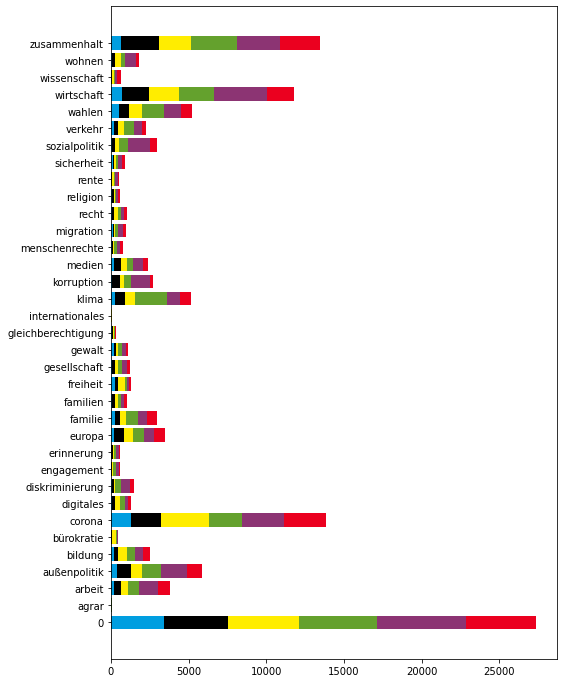

In [28]:
fig, ax = plt.subplots(figsize=(8,12))

ticks = []
for i, (name, group) in enumerate(topic_sums.groupby("topic")):
    left = 0
    for party, pgroup in group.groupby('party'):
        x = pgroup.n.values[0]
        ax.barh(i,x,color=cdict[party.lower()], left=left)
        left+=x
    ticks.append(name)
        
ax.set_yticks(range(len(ticks)))
ax.set_yticklabels(ticks)

plt.show()

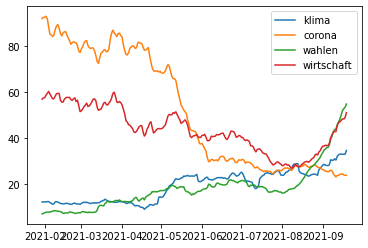

In [29]:
sub_topics = ["klima","corona","wahlen","wirtschaft"]

fig, ax = plt.subplots()

count_df = pd.DataFrame()

for c in sub_topics:
    counts = df.groupby(df.index.date)[c].sum()
    counts = counts.rolling(30).mean()
    count_df = count_df.merge(counts.to_frame(c),left_index=True, right_index=True,how="outer")
    ax.plot(counts, label=c)
    
ax.legend()

count_df.to_csv('results/comparison.csv')

plt.show()

In [30]:
group

,party,topic,n,topic_sum,party_sum
192,CDUCSU,zusammenhalt,2440.0,13435.0,24998
193,SPD,zusammenhalt,2523.0,13435.0,30496
194,LINKE,zusammenhalt,2791.0,13435.0,34417
195,GRUENE,zusammenhalt,2958.0,13435.0,31799
196,FDP,zusammenhalt,2088.0,13435.0,29091
197,AFD,zusammenhalt,635.0,13435.0,16536


In [31]:
cases = pd.read_excel('data/Fallzahlen_Kum_Tab.xlsx',sheet_name="BL_7-Tage-Fallzahlen (fixiert)",skiprows=2)
cases = cases.rename(columns={"Unnamed: 0":"Land"})
cases = cases[cases["Land"]=="Gesamt"]

cases = cases[cases.columns[1:]].melt(var_name="date")

cases.head()

,date,value
0,2020-05-06,5980
1,2020-05-07,5705
2,2020-05-08,5394
3,2020-05-09,5703
4,2020-05-10,5715


In [ ]:
cases.columns[1:]

In [ ]:
cases.tail()